In [ ]:
# import necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from keras.preprocessing import image 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import itertools
import os

In [ ]:
## read train and test data

# directories
cw_dir = os.getcwd()
data_dir = '../input/plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# different species in the data set
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
           'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed',
           'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)
length = []

# print number of images of each species in the training data
for sp in species:
    print('{} images of {}'.format(len(os.listdir(os.path.join(train_dir, sp))),sp))
    length.append(len(os.listdir(os.path.join(train_dir, sp))))
    
# read all training data
train = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train.append(['train/{}/{}'.format(sp, file), file, species_id, sp])
train_data = pd.DataFrame(train, columns=['filepath', 'file', 'species_id', 'species'])
print('')
print('train_data.shape = ', train_data.shape)

# read all test data
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test_data = pd.DataFrame(test, columns=['filepath', 'file'])
print('test_data.shape = ', test_data.shape)

263 images of Black-grass
390 images of Charlock
287 images of Cleavers
611 images of Common Chickweed
221 images of Common wheat
475 images of Fat Hen
654 images of Loose Silky-bent
221 images of Maize
516 images of Scentless Mayweed
231 images of Shepherds Purse
496 images of Small-flowered Cranesbill
385 images of Sugar beet

train_data.shape =  (4750, 4)
test_data.shape =  (794, 2)


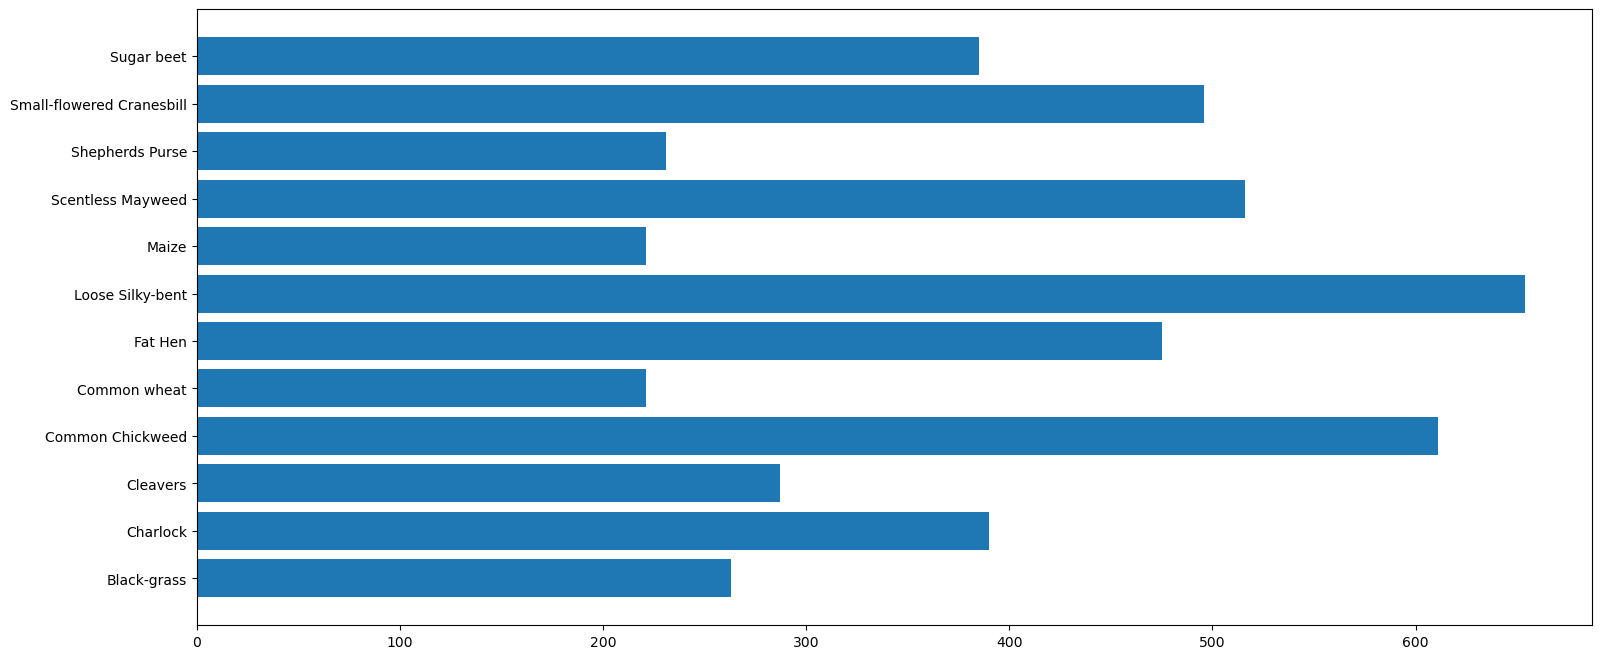

In [ ]:
# plot of plant species (target variable)
plt.figure(figsize=(18,8))
plt.xticks(rotation=0)
bar = plt.barh(species, length)

In [ ]:
train_data.head()

,filepath,file,species_id,species
0,train/Black-grass/2aa60045d.png,2aa60045d.png,0,Black-grass
1,train/Black-grass/a47cfeec4.png,a47cfeec4.png,0,Black-grass
2,train/Black-grass/c025e2886.png,c025e2886.png,0,Black-grass
3,train/Black-grass/48141d6a7.png,48141d6a7.png,0,Black-grass
4,train/Black-grass/ed540beb6.png,ed540beb6.png,0,Black-grass


In [ ]:
test_data.head()

,filepath,file
0,test/fd87b36ae.png,fd87b36ae.png
1,test/0e8492cb1.png,0e8492cb1.png
2,test/8d6acbe9b.png,8d6acbe9b.png
3,test/54b3afd58.png,54b3afd58.png
4,test/6049234e6.png,6049234e6.png


In [ ]:
# total images in the train folder
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*/*.png')))
print(image_count)

4750


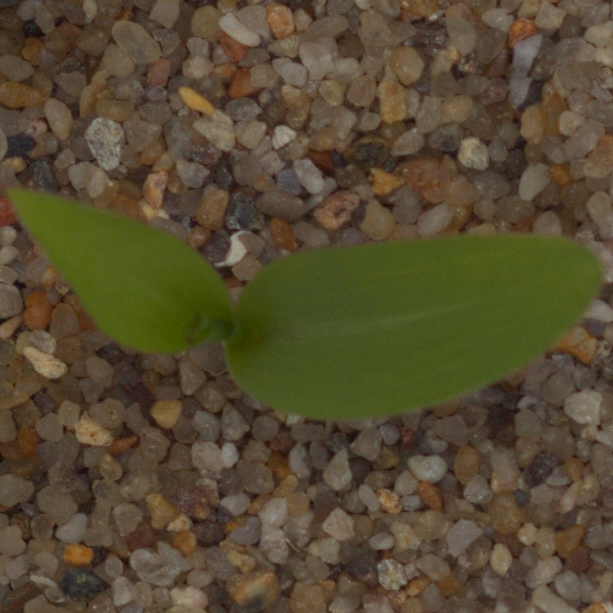

In [ ]:
# an image (maize)
maize = list(data_dir.glob('train/Maize/*'))
PIL.Image.open(str(maize[97]))

In [ ]:
# setting values
batch_size = 32
img_height = 160
img_width = 160

In [ ]:
# read images from the train directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 3800 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 950 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


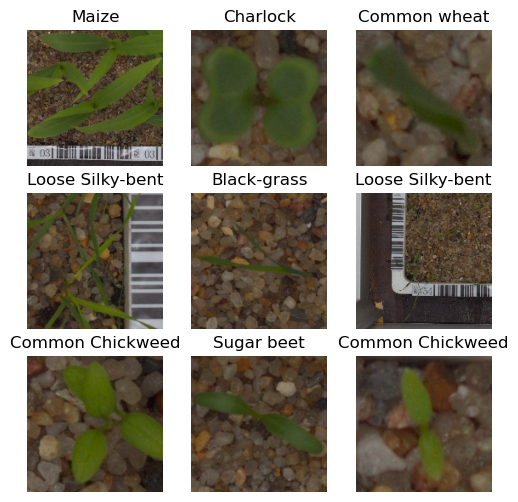

In [ ]:
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# print shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [ ]:
# performance optimization
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# rescaling
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.73354316


In [ ]:
# data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

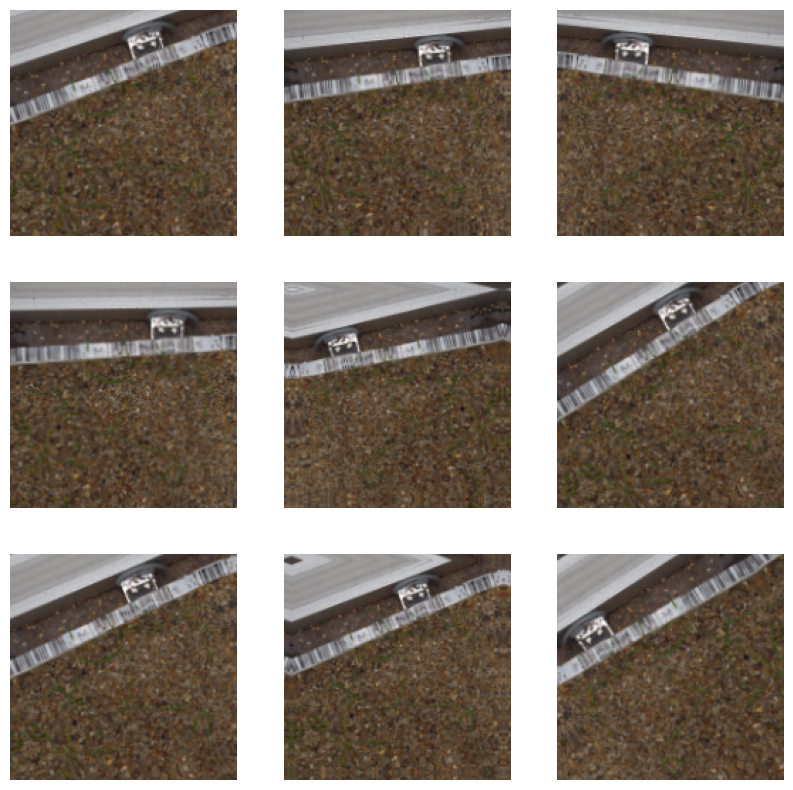

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                  

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
119/119 [==============================] - 88s 701ms/step - loss: 1.7893 - accuracy: 0.3926 - val_loss: 1.3459 - val_accuracy: 0.5432
Epoch 2/10
119/119 [==============================] - 75s 629ms/step - loss: 1.1523 - accuracy: 0.6137 - val_loss: 1.1162 - val_accuracy: 0.6326
Epoch 3/10
119/119 [==============================] - 74s 622ms/step - loss: 0.9549 - accuracy: 0.6824 - val_loss: 0.9200 - val_accuracy: 0.7189
Epoch 4/10
119/119 [==============================] - 74s 623ms/step - loss: 0.8357 - accuracy: 0.7311 - val_loss: 0.9037 - val_accuracy: 0.6937
Epoch 5/10
119/119 [==============================] - 75s 627ms/step - loss: 0.7651 - accuracy: 0.7508 - val_loss: 0.8602 - val_accuracy: 0.7126
Epoch 6/10
119/119 [==============================] - 74s 624ms/step - loss: 0.6854 - accuracy: 0.7737 - val_loss: 0.7698 - val_accuracy: 0.7516
Epoch 7/10
119/119 [==============================] - 75s 634ms/step - loss: 0.6192 - accuracy: 0.7900 - val_loss: 0.7289 - val_ac

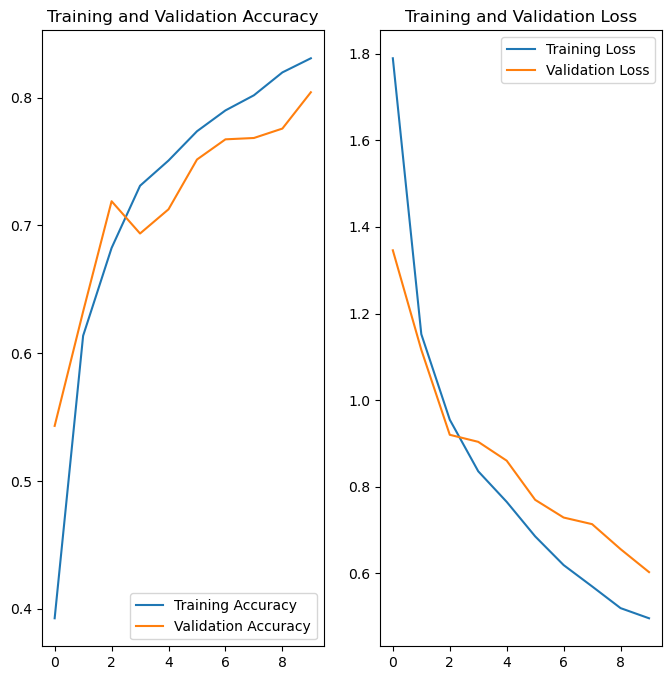

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on a test set
test_steps = len(val_ds)
test_loss, test_acc = model.evaluate(val_ds, steps=test_steps)
print('Test accuracy:', test_acc)

30/30 [==============================] - 4s 150ms/step - loss: 0.6029 - accuracy: 0.8042
Test accuracy: 0.8042105436325073


# Transfer learning: Xception

In [ ]:
weights_path = '/kaggle/input/pre-trained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
xbase_model = tf.keras.applications.Xception(input_shape=(224, 224, 3), weights=weights_path,include_top=False)

In [ ]:
x = xbase_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # add dropout layer
predictions = Dense(12, activation='softmax')(x)


In [ ]:
model = Model(inputs=xbase_model.input, outputs=predictions)

for layer in xbase_model.layers[:-10]:
    layer.trainable = False

for layer in xbase_model.layers[-10:]:
    layer.trainable = True
    
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# add L2 regularization to the dense layer
model.layers[3].kernel_regularizer = l2(0.01)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size)


Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Epoch 1/10
118/118 [==============================] - 641s 5s/step - loss: 2.0260 - accuracy: 0.3636 - val_loss: 2.5543 - val_accuracy: 0.3534
Epoch 2/10
118/118 [==============================] - 638s 5s/step - loss: 0.9841 - accuracy: 0.7192 - val_loss: 0.7177 - val_accuracy: 0.8039
Epoch 3/10
118/118 [==============================] - 634s 5s/step - loss: 0.6224 - accuracy: 0.8136 - val_loss: 0.6294 - val_accuracy: 0.8114
Epoch 4/10
118/118 [==============================] - 628s 5s/step - loss: 0.4536 - accuracy: 0.8555 - val_loss: 1.1046 - val_accuracy: 0.7069
Epoch 5/10
118/118 [==============================] - 635s 5s/step - loss: 0.3180 - accuracy: 0.8945 - val_loss: 0.5734 - val_accuracy: 0.8341
Epoch 6/10
118/118 [==============================] - 635s 5s/step - loss: 0.2525 - accuracy: 0.9178 - val_loss: 0.6200 - val_accuracy: 0.8642
Epoch 7/10
118/118 [==============================] - 627

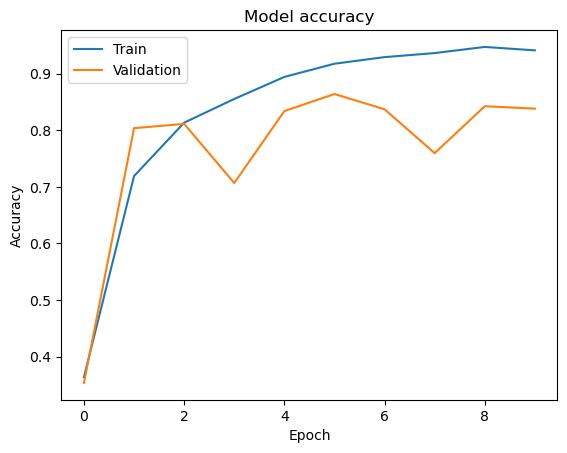

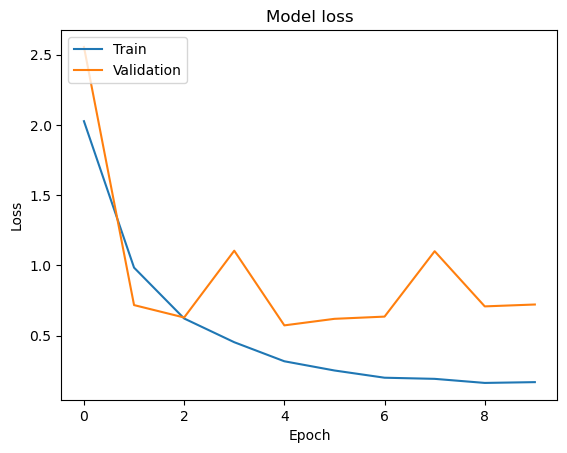

In [ ]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on a test set
test_steps = len(validation_generator)
test_loss, test_acc = model.evaluate(validation_generator, steps=test_steps)
print('Test accuracy:', test_acc)

30/30 [==============================] - 106s 4s/step - loss: 0.7156 - accuracy: 0.8405
Test accuracy: 0.840549111366272


In [ ]:
# Make predictions on the test set
y_pred = model.predict(validation_generator, steps=test_steps)

# Convert the predictions to class labels
y_pred = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = validation_generator.classes

# Get the class names
class_names = list(validation_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

30/30 [==============================] - 108s 4s/step
                           precision    recall  f1-score   support

              Black-grass       0.04      0.04      0.04        52
                 Charlock       0.15      0.15      0.15        78
                 Cleavers       0.04      0.04      0.04        57
         Common Chickweed       0.10      0.12      0.11       122
             Common wheat       0.00      0.00      0.00        44
                  Fat Hen       0.08      0.08      0.08        95
         Loose Silky-bent       0.16      0.17      0.17       130
                    Maize       0.04      0.05      0.04        44
        Scentless Mayweed       0.10      0.13      0.11       103
          Shepherds Purse       0.05      0.02      0.03        46
Small-flowered Cranesbill       0.13      0.12      0.13        99
               Sugar beet       0.10      0.08      0.09        77

                 accuracy                           0.10       947
      

In [ ]:
# Get the true labels
y_true = validation_generator.classes

# Get the predicted labels
Y_pred = model.predict(validation_generator, steps=test_steps)
y_pred = np.argmax(Y_pred, axis=1)

# Define the classes
class_names = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




30/30 [==============================] - 106s 4s/step


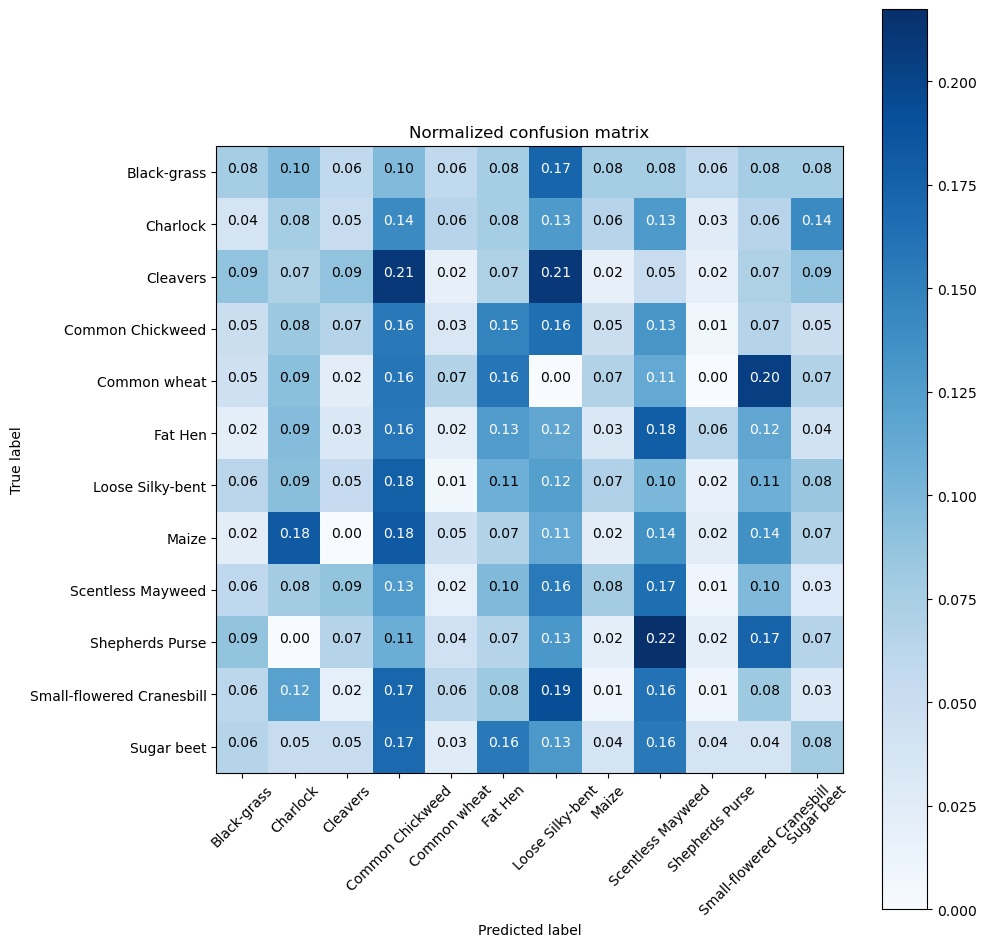

In [ ]:
# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
